In [1]:
import pickle
from datetime import date

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading in the Mazzini results 😶

Translating my names to the 2 digit codes Mazini uses that denote buoy location.
* UB1 = TB (orange)
* UB2 = TP (blue)
* MB1 = LW (red)
* MB2 = SI (teal)
* LB1 = KP (tan)
* LB2 = GI (purple)

In [2]:
# starting in 2002
freq_dict = {
    'ub1': [1, 0, 1, 4, 1, 3, 1, 1, 7, 3, 6, 2, 1, 4, 5, 7, 4, 4, 6], 
    'ub2': [4, 0, 1, 3, 3, 2, 1, 1, 5, 3, 8, 3, 0, 5, 3, 5, 2, 5, 8], 
    'mb1': [4, 1, 2, 2, 2, 2, 0, 1, 2, 3, 6, 1, 1, 2, 4, 4, 5, 4, 2], 
    'mb2': [1, 0, 1, 2, 1, 3, 0, 2, 5, 2, 4, 3, 0, 3, 4, 8, 5, 3, 5], 
    'lb1': [4, 0, 0, 1, 1, 2, 0, 0, 4, 3, 4, 0, 3, 6, 1, 2, 5, 2, 5], 
    'lb2': [2, 1, 3, 5, 3, 2, 2, 0, 2, 2, 2, 0, 0, 3, 4, 5, 8, 4, 5],
      }

In [3]:
freq = pd.DataFrame(freq_dict, index=pd.to_datetime(range(2002, 2021), format='%Y'))

## Load `mhw.detect` stats output from Geopolar

### Setup

Test points:
- middle bay: `x[23, 24]`

In [4]:
# for i in range(x.shape[0]):
#     for j in range(x.shape[1]):
#         if len(x[i, j]['time_start']) > 0:
#             print('found a mhw at', i, j)

Open zones numbers for masking

In [5]:
trad_zones_rast_ds = xr.open_dataset('../data/chesapeake_traditional_zones.nc')
trad_zones_rast = trad_zones_rast_ds.traditional_zones

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/rwegener/repos/data/chesapeake_traditional_zones.nc'

Frequency function

In [ ]:
def no_annual_events(time_arr):
    '''
    counts the number of mhw in each year and returns an array with
    the number of MHW events in each year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2022)))
    for i, yr in enumerate(range(2003, 2022)):
        year_counts[i] = np.count_nonzero(years == yr)
    
    # find the average number of events per year
    return year_counts

### Run the function on the full array

Open the pickled data structures from `stats_calc.ipynb`

In [7]:
with open('../data/avg_stats_arr0_UpperBay.pkl','rb') as f:
    avg_stats_uppbay = pickle.load(f)

In [8]:
with open('../data/avg_stats_arr0_MiddleBay.pkl','rb') as f:
    avg_stats_midbay = pickle.load(f)

In [9]:
with open('../data/avg_stats_arr0_LowerBay.pkl','rb') as f:
    avg_stats_lowbay = pickle.load(f)

[SO post](https://stackoverflow.com/questions/3379301/using-numpy-vectorize-on-functions-that-return-vectors) about generalizing `np.vectorize()` to allow for an array output. 

In [10]:
freq_sat_uppbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_uppbay)
freq_sat_midbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_midbay)
freq_sat_lowbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_lowbay)

### Aggregate across space

In [11]:
# masking out pixels not in this zone
freq_sat_uppbay[trad_zones_rast != 0] = np.nan
freq_sat_midbay[trad_zones_rast != 1] = np.nan
freq_sat_lowbay[trad_zones_rast != 2] = np.nan

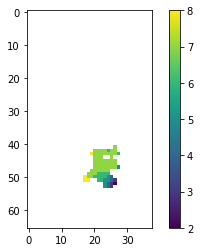

In [12]:
plt.imshow(freq_sat_uppbay[:, :, 9])
plt.colorbar()

In [13]:
freq['ub_sat'] = np.nanmean(freq_sat_uppbay, axis=(0, 1))
freq['mb_sat'] = np.nanmean(freq_sat_midbay, axis=(0, 1))
freq['lb_sat'] = np.nanmean(freq_sat_lowbay, axis=(0, 1))

## Making some nice plots

In [14]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [15]:
# plt.style.use('seaborn-talk')

In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [17]:
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

Text(0.5, 1.0, 'Frequency of MHW in the Lower Bay show\nsimilar trends in buoy and satellite data')

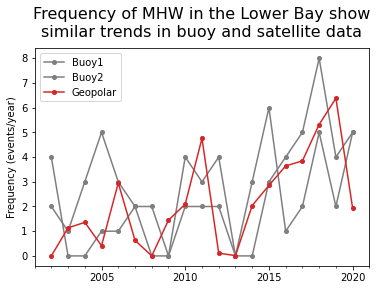

In [18]:
fig, ax = plt.subplots()

freq[['lb1', 'lb2', 'lb_sat']].plot(
    ax=ax, marker='o', markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

ax.set_ylabel('Frequency (events/year)')
ax.legend(['Buoy1', 'Buoy2', 'Geopolar'])
ax.set_title('Frequency of MHW in the Lower Bay show\n' 
             'similar trends in buoy and satellite data', fontsize=16, pad=12)

Text(0.5, 1.0, 'Frequency of MHW in the Middle Bay show\nsimilar trends in buoy and satellite data')

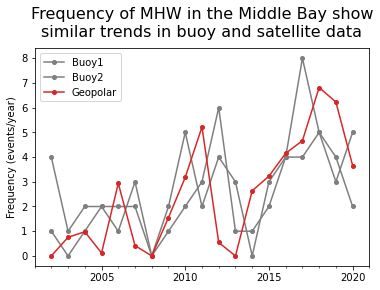

In [19]:
fig, ax = plt.subplots()

freq[['mb1', 'mb2', 'mb_sat']].plot(
    ax=ax, marker='o', markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

ax.set_ylabel('Frequency (events/year)')
ax.legend(['Buoy1', 'Buoy2', 'Geopolar'])
ax.set_title('Frequency of MHW in the Middle Bay show\n' 
             'similar trends in buoy and satellite data', fontsize=16, pad=12)

Text(0.5, 1.0, 'Frequency of MHW in the Upper Bay show\nsimilar trends in buoy and satellite data')

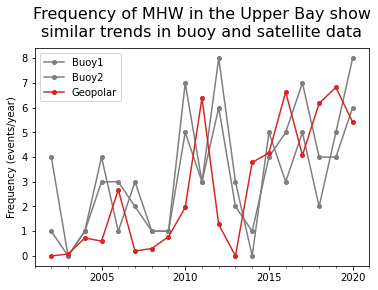

In [20]:
fig, ax = plt.subplots()

freq[['ub1', 'ub2', 'ub_sat']].plot(
    ax=ax, marker='o', markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

ax.set_ylabel('Frequency (events/year)')
ax.legend(['Buoy1', 'Buoy2', 'Geopolar'])
ax.set_title('Frequency of MHW in the Upper Bay show\n' 
             'similar trends in buoy and satellite data', fontsize=16, pad=12)

### Making a single plot with all 3 zones

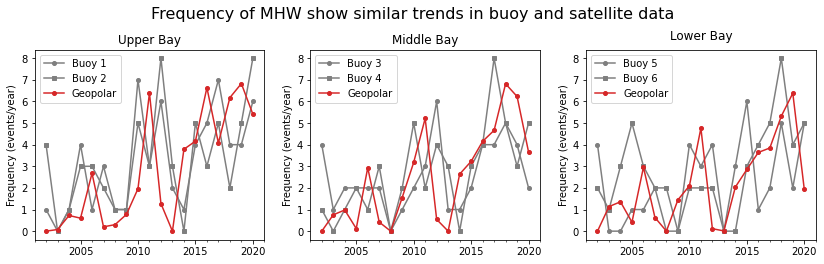

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(14, 3.5)

markers = ['-o', '-s', '-o']

# Adding data to each plot 
freq[['ub1', 'ub2', 'ub_sat']].plot(
    ax=ax1, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],  # marker='o', 
)
ax1.set_title('Upper Bay')
ax1.legend(['Buoy 1', 'Buoy 2', 'Geopolar'])

freq[['mb1', 'mb2', 'mb_sat']].plot(
    ax=ax2, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax2.set_title('Middle Bay')
ax2.legend(['Buoy 3', 'Buoy 4', 'Geopolar'])

freq[['lb1', 'lb2', 'lb_sat']].plot(
    ax=ax3, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax3.set_title('Lower Bay', pad=10)
ax3.legend(['Buoy 5', 'Buoy 6', 'Geopolar'])


# Setting params that are the same for all 3 plots
for ax in (ax1, ax2, ax3):
    ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

    ax.set_ylabel('Frequency (events/year)')

fig.suptitle('Frequency of MHW show similar trends in buoy and satellite data', y=1.05, 
            fontsize=16)

plt.savefig('./mazzini_comparison_frequency.png', dpi=350, bbox_inches='tight')


## Trends over time

In [6]:
import xarray as xr

In [9]:
import pickle

In [75]:
with open('./data/interim/event_stats_numpy_dict.pickle', 'rb') as f:
    event_stats = pickle.load(f)

In [22]:
ex = event_stats[25, 25]

In [24]:
ex

dict_keys(['time_start', 'time_end', 'time_peak', 'date_start', 'date_end', 'date_peak', 'index_start', 'index_end', 'index_peak', 'duration', 'duration_moderate', 'duration_strong', 'duration_severe', 'duration_extreme', 'intensity_max', 'intensity_mean', 'intensity_var', 'intensity_cumulative', 'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 'intensity_cumulative_relThresh', 'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', 'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline', 'n_events'])

In [8]:
sst = xr.open_dataset('./data/raw/geopolar_sst_chesapeakebay_OLD(19yrs).nc').analysed_sst

In [25]:
import pandas as pd

In [27]:
ex_pd = pd.DataFrame(ex)
ex_pd['year'] = pd.to_datetime(ex_pd['date_start']).dt.year

In [43]:
dur = ex_pd.groupby('year').mean(numeric_only=True)['duration']

In [47]:
dur.reindex(range(2002, 2023), method='ffill')

year
2003          NaN
2004    12.000000
2005     8.000000
2006     8.000000
2007    15.333333
2008    15.333333
2009    15.333333
2010     8.500000
2011     6.750000
2012    11.333333
2013    11.333333
2014    11.333333
2015    15.666667
2016     8.333333
2017    10.250000
2018    12.250000
2019     7.571429
2020    10.200000
2021     7.333333
2022     6.750000
Name: duration, dtype: float64

In [85]:
import numpy as np

In [99]:
def annual_duration(time_arr):
    '''
    return the average duration of mhw in each year
    '''
    # create the pandas dataframe
    if time_arr['n_events'] > 0:
        df = pd.DataFrame(time_arr)
        df['year'] = pd.to_datetime(df['date_start']).dt.year

        # Groupby year and extract duration
        duration = df.groupby('year').mean(numeric_only=True)['duration']

        # make sure every year is present
        duration = duration.reindex(range(2004, 2023), method='ffill')
        # return the values
        ret_value = duration.values
    else:
        ret_value = np.full(19, np.nan)
    return ret_value

In [100]:
avg_dur = np.vectorize(annual_duration, signature='()->(n)')(event_stats)


In [101]:
avg_dur[25, 25]

array([12.        ,  8.        ,  8.        , 15.33333333, 15.33333333,
       15.33333333,  8.5       ,  6.75      , 11.33333333, 11.33333333,
       11.33333333, 15.66666667,  8.33333333, 10.25      , 12.25      ,
        7.57142857, 10.2       ,  7.33333333,  6.75      ])

In [102]:
annual_dur = xr.DataArray(avg_dur, dims=('lat', 'lon', 'year'), 
             coords={'year': range(2004, 2023), 'lat': sst.lat.values,
                    'lon': sst.lon.values})

In [103]:
annual_dur

<xarray.DataArray (lat: 65, lon: 40, year: 19)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 6.        , 10.66666667, 10.66666667, ...,  9.33333333,
         11.        ,  5.        ],
        [ 7.        , 10.66666667, 10.66666667, ...,  9.33333333,
         16.        ,  5.        ],
        [ 7.        , 10.66666667,  5.        , ...,  9.66666667,
         16.        ,  5.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * year     (year) int64 2004 2005 2006 2007 2008 ... 2018 2019 2020 2021 2022
  * lat      (lat) float32 36.78 36.83 36.88 36.92 ... 39.83 39.88 39.92 39.97
  * lon      (lon) float32 -77.47 -77.43 -77.38 -77.32 ... -75.62 -75.57 -75.53

In [111]:
upper = annual_dur.where(annual_dur.lat > 38.8)
lower = annual_dur.where((annual_dur.lat < 38) & (annual_dur.lon < -75.9))

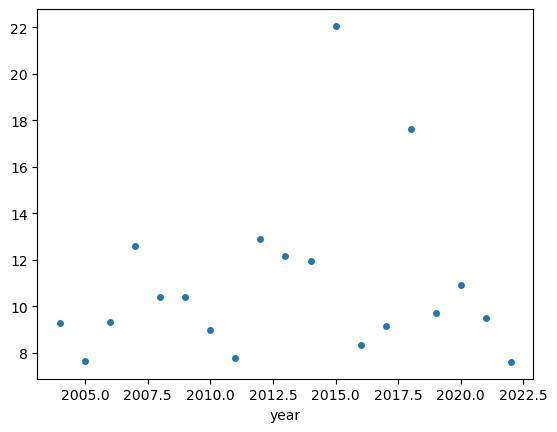

In [116]:
lower.mean(('lat', 'lon')).plot.scatter()

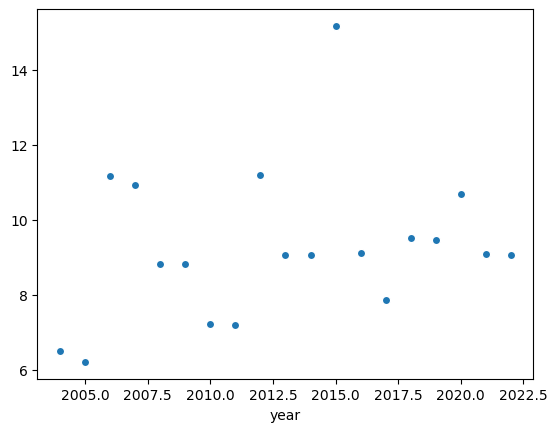

In [117]:
upper.mean(('lat', 'lon')).plot.scatter()

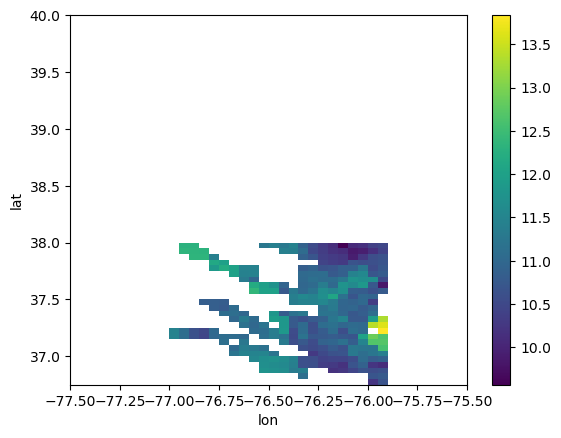

In [112]:
lower.mean('year').plot()

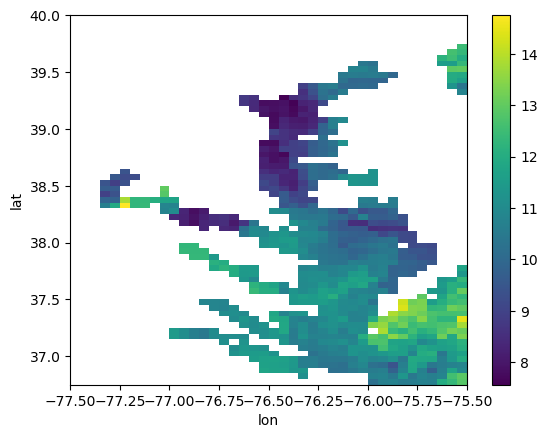

In [105]:
annual_dur.mean('year').plot()